In [2]:
import jax
import jax.numpy as jnp
import optax
import equinox as eqx
import equinox.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import json
import seaborn as sns
from matplotlib.patches import RegularPolygon

from gpt_adaln_core import SCEmbedding


Pre-computing neighbor relationships...
Starting pre-training for 4001 epochs...
Epoch 1/4001, Loss: 0.1006608
Epoch 101/4001, Loss: 0.0034651
Epoch 201/4001, Loss: 0.0046875
Epoch 301/4001, Loss: 0.0000000
Epoch 401/4001, Loss: 0.0000000
Epoch 501/4001, Loss: 0.0000000
Epoch 601/4001, Loss: 0.0000000
Epoch 701/4001, Loss: 0.0000000
Epoch 801/4001, Loss: 0.0000000
Epoch 901/4001, Loss: 0.0000000
Epoch 1001/4001, Loss: 0.0000000
Epoch 1101/4001, Loss: 0.0000000
Epoch 1201/4001, Loss: 0.0017383
Epoch 1301/4001, Loss: 0.0000000
Epoch 1401/4001, Loss: 0.0000000
Epoch 1501/4001, Loss: 0.0000000
Epoch 1601/4001, Loss: 0.0112453
Epoch 1701/4001, Loss: 0.0000000
Epoch 1801/4001, Loss: 0.0000000
Epoch 1901/4001, Loss: 0.0000000
Epoch 2001/4001, Loss: 0.0000000
Epoch 2101/4001, Loss: 0.0000000
Epoch 2201/4001, Loss: 0.0000000
Epoch 2301/4001, Loss: 0.0000000
Epoch 2401/4001, Loss: 0.0000000
Epoch 2501/4001, Loss: 0.0000000
Epoch 2601/4001, Loss: 0.0000000
Epoch 2701/4001, Loss: 0.0000000
Epoch 2

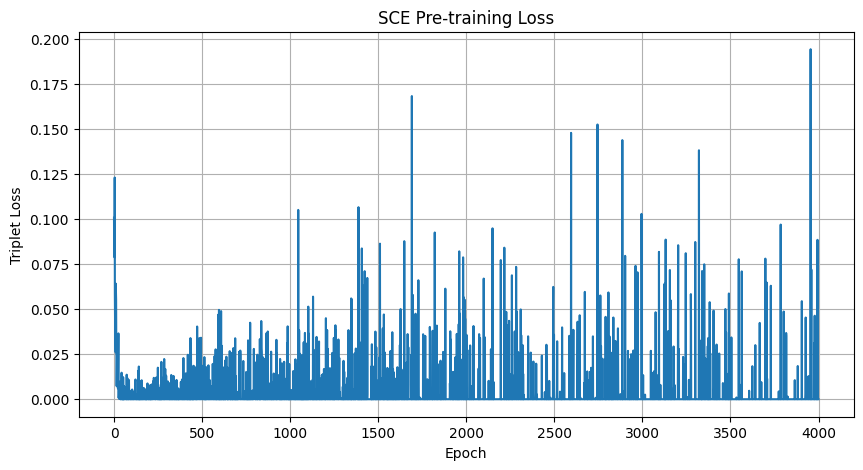

In [59]:
HEX_DIRS_ODD = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (1, -1)]
HEX_DIRS_EVEN  = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, 1), (1, 1)]

def neighbors_evenr(idx: int, G: int) -> np.ndarray:
    r, c = divmod(idx, G)
    dirs = HEX_DIRS_EVEN if (r & 1) == 0 else HEX_DIRS_ODD
    out = []
    for dr, dc in dirs:
        rr, cc = r + dr, c + dc
        if 0 <= rr < G and 0 <= cc < G:
            out.append(rr * G + cc)
    return np.array(out, dtype=np.int32)

def build_pos_neg_sets(G: int):
    N = G * G
    all_idx = np.arange(N, dtype=np.int32)
    pos_sets, neg_sets = [], []
    for i in range(N):
        pos = neighbors_evenr(i, G)
        mask = np.ones(N, dtype=bool)
        mask[i] = False
        mask[pos] = False
        neg = all_idx[mask]
        pos_sets.append(pos)
        neg_sets.append(neg)
    return pos_sets, neg_sets

def sample_triplets(key, batch_size, G, pos_sets, neg_sets):
    N = G * G
    key, ak = jax.random.split(key)
    anchors = jax.random.randint(ak, (batch_size,), 0, N, dtype=jnp.int32)

    # Use numpy choice for simplicity (fine outside jit)
    anchors_np = np.asarray(anchors)
    pos = np.array([np.random.choice(pos_sets[a]) for a in anchors_np], dtype=np.int32)
    neg = np.array([np.random.choice(neg_sets[a]) for a in anchors_np], dtype=np.int32)
    return anchors, jnp.array(pos), jnp.array(neg)

@eqx.filter_jit
def train_step(model, opt_state, anchors, positives, negatives, optimizer, triplet=True, margin=1.0):
    def loss_fn(model):
        anchor_emb = jax.vmap(model)(anchors)
        positive_emb = jax.vmap(model)(positives)
        negative_emb = jax.vmap(model)(negatives)
        
        dist_pos = jnp.sum(jnp.square(anchor_emb - positive_emb), axis=-1)
        dist_neg = jnp.sum(jnp.square(anchor_emb - negative_emb), axis=-1)
        
        if triplet:    
            loss = optax.losses.triplet_margin_loss(
                anchors=anchor_emb,
                positives=positive_emb,
                negatives=negative_emb,
                margin=margin
            )
            return jnp.mean(loss)
        else:
            loss = jax.nn.relu(dist_pos - dist_neg + margin)
            return jnp.mean(loss)

    loss, grads = eqx.filter_value_and_grad(loss_fn)(model)
    updates, new_opt_state = optimizer.update(grads, opt_state, model)
    new_model = eqx.apply_updates(model, updates)
    return new_model, new_opt_state, loss

num_embeddings = 64
embedding_dim = 256
batch_size = 256
num_epochs = 4001
learning_rate = 1e-3
margin = 0.001
seed = 42
triplet = True

key = jax.random.PRNGKey(seed)

model_key, train_key = jax.random.split(key)
model = SCEmbedding(num_embeddings, embedding_dim, key=model_key)
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

print("Pre-computing neighbor relationships...")
G = 8
pos_sets, neg_sets = build_pos_neg_sets(G)

losses = []
print(f"Starting pre-training for {num_epochs} epochs...")
for epoch in range(num_epochs):
    train_key, key = jax.random.split(train_key)
    anchors, positives, negatives = sample_triplets(key, batch_size=64, G=G,
                                                pos_sets=pos_sets, neg_sets=neg_sets)
    model, opt_state, loss = train_step(model, opt_state, anchors, positives, negatives, optimizer, triplet, margin)
    losses.append(loss.item())
    if (epoch) % 100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.7f}")

print("Pre-training complete.")
with open("sce_model.eqx", 'wb') as f:
    eqx.tree_serialise_leaves(f, model)
print("Saved final embeddings to sce_embeddings.npy")

plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title("SCE Pre-training Loss")
plt.xlabel("Epoch")
plt.ylabel("Triplet Loss")
plt.grid(True)
# plt.savefig("sce_loss_curve.png")
print("Saved loss curve plot to sce_loss_curve.png")

Calculating cosine similarity matrix...


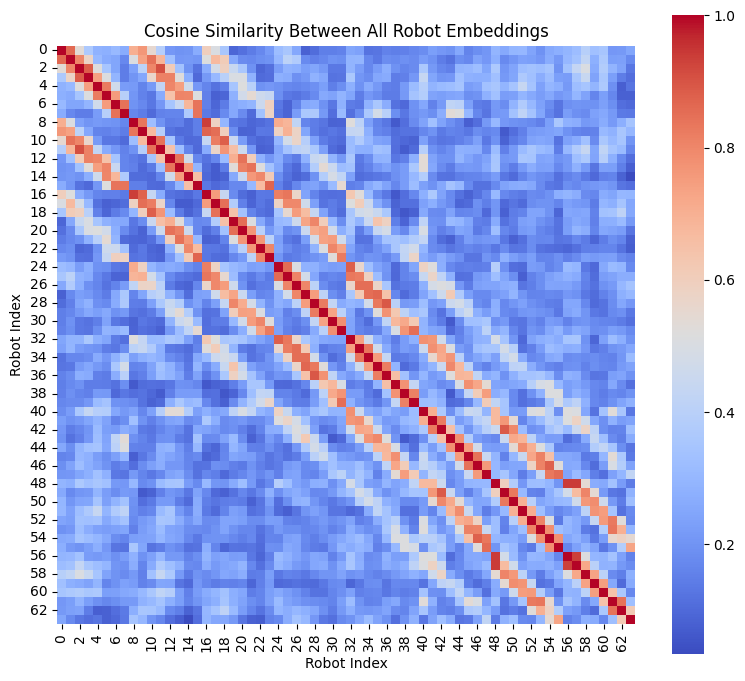

Saved cosine_similarity_heatmap.png
Generating hexagonal grid plot for reference robot #34...


/tmp/ipykernel_245392/278775869.py:61: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  hexagon = RegularPolygon(


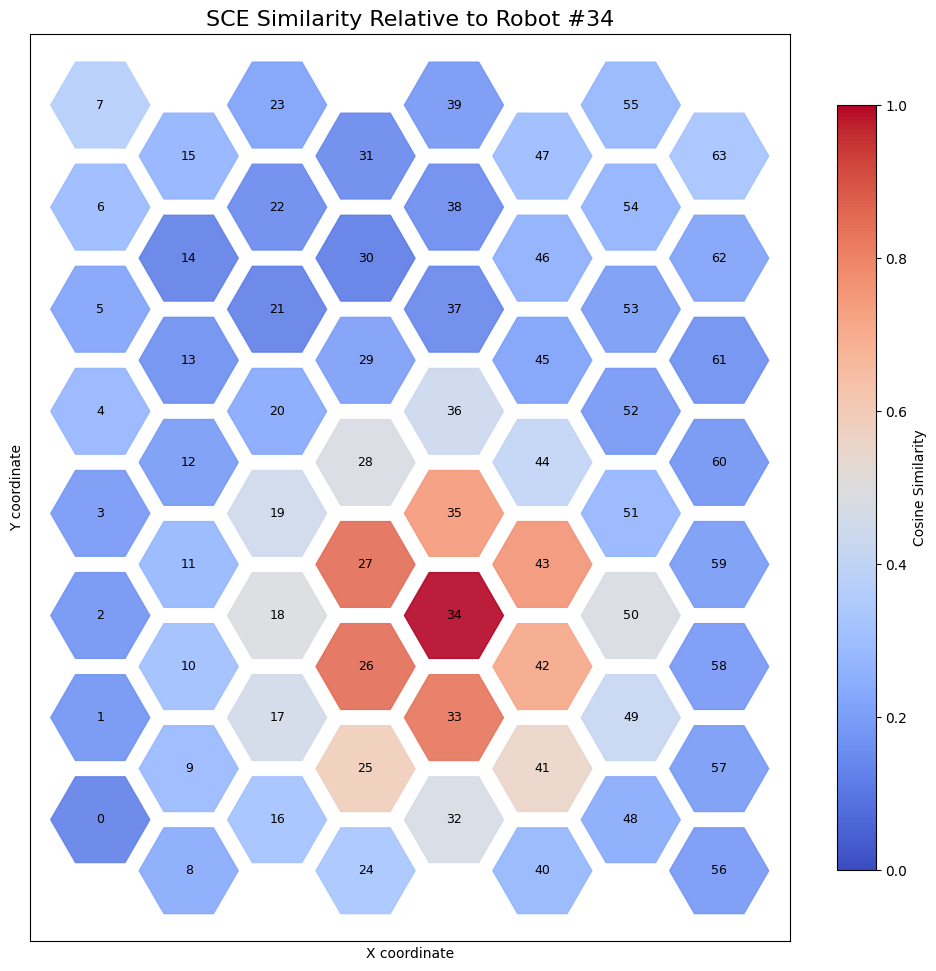

Saved hexagonal_grid_visualization.png


In [60]:
model_path = "./sce_model.eqx"
reference_robot_idx = 34

num_embeddings = 64
embedding_dim = 256
key = jax.random.PRNGKey(0)

sce_template = SCEmbedding(num_embeddings, embedding_dim, key=key)
with open(model_path, 'rb') as f:
    sce_template = eqx.tree_deserialise_leaves(f, sce_template)

all_indices = jnp.arange(num_embeddings)
all_embeddings = jax.vmap(sce_template)(all_indices)

print("Calculating cosine similarity matrix...")
norm_embeddings = all_embeddings / jnp.linalg.norm(all_embeddings, axis=1, keepdims=True)
cos_sim_matrix = norm_embeddings @ norm_embeddings.T

plt.figure(figsize=(8, 7))
sns.heatmap(cos_sim_matrix, cmap='coolwarm', square=True)
plt.title("Cosine Similarity Between All Robot Embeddings")
plt.xlabel("Robot Index")
plt.ylabel("Robot Index")
plt.tight_layout()
# plt.savefig("cosine_similarity_heatmap.png")
plt.show()
print("Saved cosine_similarity_heatmap.png")
plt.close()

print(f"Generating hexagonal grid plot for reference robot #{reference_robot_idx}...")
grid_size = 8
num_embeddings = grid_size * grid_size
rb_pos_world = np.zeros((grid_size, grid_size, 2))
for i in range(grid_size):
    for j in range(grid_size):
        if i % 2 != 0:
            pos = np.array((i * 0.0375, j * 0.043301 - 0.02165))
        else:
            pos = np.array((i * 0.0375, j * 0.043301))
        rb_pos_world[i, j] = pos

similarities = cos_sim_matrix[reference_robot_idx]
fig, ax = plt.subplots(figsize=(10, 10))

# --- FIX 1: Set vmin to -1 for a more accurate color mapping ---
norm = plt.Normalize(vmin=0, vmax=1)
cmap = plt.get_cmap('coolwarm')

# --- FIX 2: Manually calculate and set the plot bounds ---
# Get the min/max coordinates of your grid
x_coords = rb_pos_world[:, :, 0].flatten()
y_coords = rb_pos_world[:, :, 1].flatten()
# Add a small padding so the hexagons aren't cut off
padding = 0.03 
ax.set_xlim(x_coords.min() - padding, x_coords.max() + padding)
ax.set_ylim(y_coords.min() - padding, y_coords.max() + padding)
# --- End of Fix ---

for i in range(num_embeddings):
    row, col = i // grid_size, i % grid_size
    hexagon = RegularPolygon(
        (rb_pos_world[row, col, 0], rb_pos_world[row, col, 1]),
        numVertices=6,
        radius=0.021,
        orientation=np.radians(30),
        color=cmap(norm(similarities[i])),
        alpha=0.9,
        edgecolor='black'
    )
    ax.add_patch(hexagon)
    ax.text(rb_pos_world[row, col, 0], rb_pos_world[row, col, 1],
            str(i), ha='center', va='center', fontsize=9, color='black')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, orientation='vertical', label='Cosine Similarity', shrink=0.8)

ax.set_title(f"SCE Similarity Relative to Robot #{reference_robot_idx}", fontsize=16)
ax.set_xlabel("X coordinate")
ax.set_ylabel("Y coordinate")
ax.set_aspect('equal')
ax.grid(False)
# Removing the automatic ticks is fine now that we've set the bounds manually
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()
# plt.savefig("hexagonal_grid_visualization.png", dpi=300)
print("Saved hexagonal_grid_visualization.png")
plt.close()